kaggleコンペpetfinder　https://www.kaggle.com/c/petfinder-adoption-prediction
をfastaiやpytorch Lightningのような
ラッパーライブラリなしで実装したノートブック

参照
https://www.kaggle.com/yasufuminakama/petfinder-efficientnet-b0-starter-training

# Training 画像モデル

## 準備

### Library

In [39]:
import os
import gc
import sys
import math
import time
import random
import shutil
import seaborn as sns
import pickle
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
from IPython.core.display import display
import matplotlib.pyplot as plt
import torchvision

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as transforms
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')
import timm
import lightgbm as lgb

from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')
torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

OUTPUT_DIR = './my_model/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [40]:
import torch
torch.cuda.is_available()

True

### Config

In [79]:
class CFG:
    apex=False
    debug=False
    print_freq=10
    num_workers=4
    size=224 ##モデルによって変える。
    model_name='tf_efficientnet_b0_ns' ##モデルによって変える
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=2
    factor=0.2 # ReduceLROnPlateau
    patience=4 # ReduceLROnPlateau
    eps=1e-6 # ReduceLROnPlateau
    T_max=3 # CosineAnnealingLR
    T_0=3 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=16
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=1
    target_col='Pawpularity'
    n_fold=2
    trn_fold=[0, 1]
    train=True
    grad_cam=True
    isTransFormer = False ##モデルによって変える
    ##メモを書く"
    note ="ベースライン"
    color_space = "COLOR_BGR2RGB"
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

#seed値を固定
def set_seed(seed =42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
set_seed(seed=CFG.seed)

### wandb

In [80]:
# ====================================================
# wandb
# ====================================================
import wandb
wandb.login

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="petfinder_myproject", 
                 config=class2dict(CFG),
                 name = CFG.model_name + "+"+CFG.note,
                 job_type="train",)

### deta load

In [73]:
train = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
test = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')

def get_train_file_path(image_id):
    return "../input/petfinder-pawpularity-score/train/{}.jpg".format(image_id)

def get_test_file_path(image_id):
    return "../input/petfinder-pawpularity-score/test/{}.jpg".format(image_id)

train['file_path'] = train['Id'].apply(get_train_file_path)
test['file_path'] = test['Id'].apply(get_test_file_path)

display(train.head())
display(test.head())

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/001...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,file_path
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1,../input/petfinder-pawpularity-score/test/4128...
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0,../input/petfinder-pawpularity-score/test/43a2...
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1,../input/petfinder-pawpularity-score/test/4e42...
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0,../input/petfinder-pawpularity-score/test/80bc...
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0,../input/petfinder-pawpularity-score/test/8f49...


### CV Split

In [81]:
num_bins = int(np.floor(1+np.log2(len(train))))
train["bins"] = pd.cut(train[CFG.target_col], bins=num_bins, labels=False)
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["bins"])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby(['fold', "bins"]).size())
train.to_pickle(OUTPUT_DIR+'train.pkl')

fold  bins
0     0        165
      1        209
      2        551
      3       1014
      4        941
      5        650
      6        420
      7        267
      8        203
      9        137
      10        99
      11        70
      12        51
      13       179
1     0        165
      1        209
      2        550
      3       1015
      4        942
      5        649
      6        419
      7        266
      8        203
      9        137
      10        99
      11        70
      12        52
      13       180
dtype: int64

### Dataset

In [84]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        #cv2は画像読み込みなどに使われるライブラリ
        image = cv2.imread(file_path)
        #色空間を変換
        #TODO 変換しない場合を実験
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image

In [85]:
def get_transforms(*, data):
    if data == 'train':
        return transforms.Compose([
            # transforms.Resize(300 , 300),
            # transforms.CenterCrop(100, 100),
            # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            transforms.RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return transforms.Compose([
            transforms.Resize(CFG.size, CFG.size),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

### サンプル

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

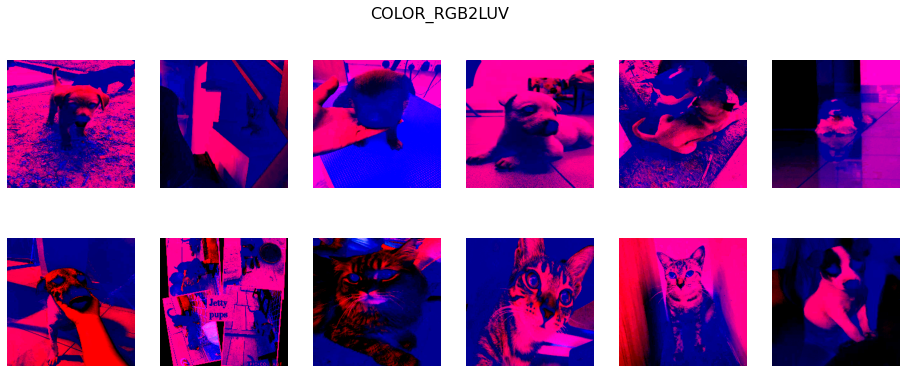

In [86]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle(CFG.color_space, fontsize = 16)
for i in range(0, 2*6):
    sample = train_dataset[i][0]
    img = np.transpose(sample, (1, 2, 0))
    x = i // 6
    y = i % 6
    axes[x, y].imshow(img, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

## model

### model

In [87]:
class CnnModel(nn.Module):
    def __init__(self, cfg, pretrained=True):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.fc = nn.Linear(self.n_features, self.cfg.target_size)

    def feature(self, image):
        feature = self.model(image)
        return feature
        
    def forward(self, image):
        feature = self.feature(image)
        output = self.fc(feature)
        return output


class TransformerModel(nn.Module):
    def __init__(self, cfg, pretrained=True):
        super().__init__()
        self.cfg = cfg
        self.model   = timm.create_model(self.cfg.model_name, pretrained=pretrained, num_classes=0, in_chans=3)
        num_features = self.model.num_features
        self.linear  = nn.Linear(num_features, 1)
        
    def feature(self, image):
        feature = self.model(image)
        return feature
    
    def forward(self, x):
        x = self.model(x)
        output = self.linear(x)
        return output

### function for train loop



In [64]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

def get_RMSE(y_true,y_pred):
    ## squared=FalseでRSCMになる。※TrueでMSE
    score = mean_squared_error(y_true= y_true ,y_pred=y_pred,squared=False)
    return score

#RSMEを出力
def get_result(result_df):
    preds = result_df['preds'].values
    labels = result_df[CFG.target_col].values
    score = get_RMSE(labels, preds)
    LOGGER.info(f'Score: {score:<.4f}')
    wandb.log({f"CV score": score})

def train_fn(fold,train_loader,model,criterion,optimizer,epoch,scheduler,device):
    model.train()
    losses = AverageMeter()
    global_step = 0
    for step,(images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)

        # record loss
        losses.update(loss.item(), batch_size)

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader),                         
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        wandb.log({f"[fold{fold}] loss": losses.val,
                   f"[fold{fold}] lr": scheduler.get_lr()[0]})

def valid_fn(valid_loader, model, criterion, device):
    #推論モードに切り替え
    model.eval()
    losses = AverageMeter()
    preds = []
    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


### train loop

In [65]:
def train_loop(folds, fold):
    LOGGER.info(f"========== fold: {fold} training ==========")

    #dataset
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values
    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='train'))

    #dataloader
    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, #TODO why
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    #model
    if (CFG.isTransFormer):
        model = TransformerModel(CFG, pretrained=True)
    else:
        model = CnnModel(CFG, pretrained=True)
    model.to(device)
    
    optimizer = Adam(model.parameters(),lr= CFG.lr,weight_decay=CFG.weight_decay,amsgrad=False)
    scheduler = get_scheduler(optimizer)
    criterion = RMSELoss()

    #train loop
    best_score = np.inf
    best_loss = np.inf
    for epoch in range(CFG.epochs):
        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        # validation
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)

        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_RMSE(valid_labels, preds)
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        wandb.log({f"[fold{fold}] epoch": epoch+1, 
                   f"[fold{fold}] avg_train_loss": avg_loss, 
                   f"[fold{fold}] avg_val_loss": avg_val_loss,
                   f"[fold{fold}] score": score})
        if score < best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
        valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth', 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds

## main

In [88]:
def main():
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        #結果を保存
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    wandb.finish()
if __name__ == '__main__':
    main()

========== fold: 0 training ==========
========== fold: 0 training ==========


Epoch: [1][0/309] Loss: 38.5706(38.5706) Grad: 3.2970  LR: 0.000100  
Epoch: [1][10/309] Loss: 47.7862(42.7315) Grad: 3.1039  LR: 0.000100  
Epoch: [1][20/309] Loss: 38.8788(41.4705) Grad: 3.2610  LR: 0.000100  
Epoch: [1][30/309] Loss: 41.5651(41.4101) Grad: 3.8029  LR: 0.000100  
Epoch: [1][40/309] Loss: 45.0348(42.0919) Grad: 4.5205  LR: 0.000100  
Epoch: [1][50/309] Loss: 35.8508(41.8146) Grad: 5.2481  LR: 0.000100  
Epoch: [1][60/309] Loss: 39.1895(41.7687) Grad: 6.0275  LR: 0.000100  
Epoch: [1][70/309] Loss: 38.1693(40.7921) Grad: 6.9275  LR: 0.000100  
Epoch: [1][80/309] Loss: 41.4960(40.5827) Grad: 8.5064  LR: 0.000100  
Epoch: [1][90/309] Loss: 41.6022(40.2935) Grad: 8.4463  LR: 0.000100  
Epoch: [1][100/309] Loss: 45.5863(39.7914) Grad: 8.6016  LR: 0.000100  
Epoch: [1][110/309] Loss: 36.8910(39.5137) Grad: 10.1710  LR: 0.000100  
Epoch: [1][120/309] Loss: 33.1270(39.3122) Grad: 13.2059  LR: 0.000100  
Epoch: [1][130/309] Loss: 37.5821(39.3133) Grad: 13.0029  LR: 0.000100  


Epoch 1 - Score: 27.8011
Epoch 1 - Score: 27.8011
Epoch 1 - Save Best Score: 27.8011 Model
Epoch 1 - Save Best Score: 27.8011 Model


EVAL: [154/155] Loss: 34.9050(27.4851) 
Epoch: [2][0/309] Loss: 17.9157(17.9157) Grad: 15.0878  LR: 0.000057  
Epoch: [2][10/309] Loss: 29.0232(25.8241) Grad: 18.3893  LR: 0.000057  
Epoch: [2][20/309] Loss: 24.5484(25.3464) Grad: 24.1819  LR: 0.000057  
Epoch: [2][30/309] Loss: 26.0963(25.5026) Grad: 20.6132  LR: 0.000057  
Epoch: [2][40/309] Loss: 25.6005(25.7793) Grad: 20.4301  LR: 0.000057  
Epoch: [2][50/309] Loss: 16.5451(25.3750) Grad: 45.6688  LR: 0.000057  
Epoch: [2][60/309] Loss: 29.3292(25.1819) Grad: 19.5660  LR: 0.000057  
Epoch: [2][70/309] Loss: 18.2450(24.8549) Grad: 21.5832  LR: 0.000057  
Epoch: [2][80/309] Loss: 26.5572(25.0366) Grad: 28.3288  LR: 0.000057  
Epoch: [2][90/309] Loss: 22.2103(24.7680) Grad: 28.3487  LR: 0.000057  
Epoch: [2][100/309] Loss: 30.1030(24.9385) Grad: 28.5373  LR: 0.000057  
Epoch: [2][110/309] Loss: 19.7983(24.9680) Grad: 48.3224  LR: 0.000057  
Epoch: [2][120/309] Loss: 16.7904(24.7161) Grad: 33.4967  LR: 0.000057  
Epoch: [2][130/309] Lo

Epoch 2 - Score: 21.4740
Epoch 2 - Score: 21.4740
Epoch 2 - Save Best Score: 21.4740 Model
Epoch 2 - Save Best Score: 21.4740 Model


EVAL: [154/155] Loss: 27.4048(21.1004) 


========== fold: 0 result ==========
========== fold: 0 result ==========
Score: 21.4740
Score: 21.4740
========== fold: 1 training ==========
========== fold: 1 training ==========


Epoch: [1][0/309] Loss: 35.0910(35.0910) Grad: 3.1195  LR: 0.000100  
Epoch: [1][10/309] Loss: 42.2008(42.2393) Grad: 3.6896  LR: 0.000100  
Epoch: [1][20/309] Loss: 41.1611(43.0085) Grad: 3.3082  LR: 0.000100  
Epoch: [1][30/309] Loss: 35.5635(41.8838) Grad: 3.8168  LR: 0.000100  
Epoch: [1][40/309] Loss: 47.3847(42.7614) Grad: 4.3143  LR: 0.000100  
Epoch: [1][50/309] Loss: 33.1495(42.2861) Grad: 5.4114  LR: 0.000100  
Epoch: [1][60/309] Loss: 29.8927(41.8757) Grad: 6.0083  LR: 0.000100  
Epoch: [1][70/309] Loss: 57.8410(41.7846) Grad: 7.0247  LR: 0.000100  
Epoch: [1][80/309] Loss: 40.4549(41.3388) Grad: 7.2833  LR: 0.000100  
Epoch: [1][90/309] Loss: 33.6072(40.8178) Grad: 8.0212  LR: 0.000100  
Epoch: [1][100/309] Loss: 39.1232(40.1911) Grad: 9.1708  LR: 0.000100  
Epoch: [1][110/309] Loss: 30.4522(39.4943) Grad: 10.1241  LR: 0.000100  
Epoch: [1][120/309] Loss: 45.6655(39.5524) Grad: 10.1315  LR: 0.000100  
Epoch: [1][130/309] Loss: 30.3520(39.1134) Grad: 10.7419  LR: 0.000100  


Epoch 1 - Score: 27.7077
Epoch 1 - Score: 27.7077
Epoch 1 - Save Best Score: 27.7077 Model
Epoch 1 - Save Best Score: 27.7077 Model


EVAL: [154/155] Loss: 25.8689(27.4137) 
Epoch: [2][0/309] Loss: 15.2124(15.2124) Grad: 17.7540  LR: 0.000057  
Epoch: [2][10/309] Loss: 40.1897(29.5042) Grad: 21.8697  LR: 0.000057  
Epoch: [2][20/309] Loss: 38.0087(27.2863) Grad: 17.3711  LR: 0.000057  
Epoch: [2][30/309] Loss: 36.1343(27.5625) Grad: 19.1711  LR: 0.000057  
Epoch: [2][40/309] Loss: 22.6905(27.1798) Grad: 24.6118  LR: 0.000057  
Epoch: [2][50/309] Loss: 31.1530(26.8273) Grad: 27.5398  LR: 0.000057  
Epoch: [2][60/309] Loss: 20.3754(26.5433) Grad: 25.4262  LR: 0.000057  
Epoch: [2][70/309] Loss: 12.7560(26.0272) Grad: 32.7690  LR: 0.000057  
Epoch: [2][80/309] Loss: 19.6722(25.2966) Grad: 24.4192  LR: 0.000057  
Epoch: [2][90/309] Loss: 20.0766(25.2220) Grad: 30.7152  LR: 0.000057  
Epoch: [2][100/309] Loss: 14.9903(25.4190) Grad: 18.9399  LR: 0.000057  
Epoch: [2][110/309] Loss: 18.9316(24.9527) Grad: 47.3040  LR: 0.000057  
Epoch: [2][120/309] Loss: 19.9788(24.7399) Grad: 28.7246  LR: 0.000057  
Epoch: [2][130/309] Lo

Epoch 2 - Score: 20.7940
Epoch 2 - Score: 20.7940
Epoch 2 - Save Best Score: 20.7940 Model
Epoch 2 - Save Best Score: 20.7940 Model
========== fold: 1 result ==========
========== fold: 1 result ==========
Score: 20.7940
Score: 20.7940
========== CV ==========
========== CV ==========
Score: 21.1368
Score: 21.1368


EVAL: [154/155] Loss: 17.3102(20.4793) 



# Training　LGB 

## 設定

### directory設定

In [ ]:
import os

OUTPUT_DIR = './my_model/'
#TODO
MODEL_DIR = './my_model/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

### Config

In [ ]:

class CNN_CFG:
    num_workers=4
    size=224
    batch_size=16
    model_name='tf_efficientnet_b0_ns'
    seed=42
    target_size=1
    target_col='Pawpularity'
    n_fold=2

class LGM_CFG:
    objective= 'regression'
    metric =  'rmse'
    boosting_type = 'gbdt'
    learning_rate =  0.01
    seed = 42
    max_depth = -1
    min_data_in_leaf =  10
    verbosity = -1

### WandB

In [ ]:
# ====================================================
# wandb
# ====================================================
import wandb
wandb.login

def class3dict(f):
    param = dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__') or name == '__annotations__')
    for key,value in param['__annotations__'].items():
      param[key] = value
    param.pop('__annotations__')
    return param
lgb_param  = class3dict(LGM_CFG)

run = wandb.init(project="petfinder_myproject", 
                 config= lgb_param,
                 name = "LBGM+"+CNN_CFG.model_name,
                 job_type="train",
                 notes ="hoge")

### CV split

In [ ]:
train = pd.read_pickle('./my_model/train.pkl')

display(train.groupby(['fold', "bins"]).size())

## Model

### function

In [ ]:
def run_single_lightgbm(param, train, features, target, fold=0, categorical=[]):
    #dataload
    train[[f"img_{i}" for i in np.arange(1280)]] = IMG_FEATURES[fold]
    trn_idx = train[train.fold != fold].index
    val_idx = train[train.fold == fold].index
    LOGGER.info(f'train size : {len(trn_idx)}  valid size : {len(val_idx)}')
    if categorical == []:
        trn_data = lgb.Dataset(train.iloc[trn_idx][features].values, label=target.iloc[trn_idx].values)
        val_data = lgb.Dataset(train.iloc[val_idx][features].values, label=target.iloc[val_idx].values)
    else:
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx].values, categorical_feature=categorical)
        val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx].values, categorical_feature=categorical)
    num_round = 10000

    #train
    clf = lgb.train(param, 
                    trn_data,
                    num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=10,
                    early_stopping_rounds=10)
    LOGGER.info(f'Dumping model with pickle... lightgbm_fold{fold}.pkl')
    with open(OUTPUT_DIR+f'lightgbm_fold{fold}.pkl', 'wb') as fout:
        #モデルをシリアライズ化して保存
        pickle.dump(clf, fout)
    
    #予測
    oof = np.zeros(len(train))
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    score = get_RMSE(target.iloc[val_idx].values, oof[val_idx])
    LOGGER.info(f"fold{fold} score: {score:<.5f}")
    
    #future_importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold

    return oof, fold_importance_df, val_idx


def run_kfold_lightgbm(param, train, features, target, n_fold=5, categorical=[]):
    oof = np.zeros(len(train))
    feature_importance_df = pd.DataFrame()
    val_idxes = []
    
    for fold in range(n_fold):
        LOGGER.info(f"===== Fold {fold} =====")
        _oof, fold_importance_df, val_idx = run_single_lightgbm(param, 
                                                                train, features, target, 
                                                                fold=fold, categorical=categorical)
        oof += _oof
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        val_idxes.append(val_idx)
    
    val_idxes = np.concatenate(val_idxes)
    score = get_RMSE(target.iloc[val_idxes].values, oof[val_idxes])
    LOGGER.info(f"CV score: {score:<.5f}")
    
    return oof, feature_importance_df, val_idxes


def show_feature_importance(feature_importance_df):
    cols = (feature_importance_df[["Feature", "importance"]]
                .groupby("Feature").mean().sort_values(by="importance", ascending=False)[:50].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    plt.figure(figsize=(8, 16))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR+'feature_importance_df_lightgbm.png')

def get_features(test_loader, model, device):
    model.eval()
    features = []
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    for step, (images) in tk0:
        images = images.to(device)
        batch_size = images.size(0)
        with torch.no_grad():
            feature = model.feature(images)
        features.append(feature.to('cpu').numpy())
    features = np.concatenate(features)
    return features

In [ ]:
IMG_FEATURES = []
test_dataset = TestDataset(train, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, 
                         batch_size=CFG.batch_size * 2, #why?
                         shuffle=False, 
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
for fold in range(CFG.n_fold):
    model = CnnModel(CFG, pretrained=False)
    state = torch.load(MODEL_DIR+f'{CFG.model_name}_fold{fold}_best.pth', 
                       map_location=torch.device('cpu'))['model']
    model.load_state_dict(state)
    model.to(device)
    features = get_features(test_loader, model, device)
    IMG_FEATURES.append(features)
    del state; gc.collect()
    torch.cuda.empty_cache()

In [ ]:
target = train['Pawpularity']
features = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
            'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'] + [f"img_{i}" for i in np.arange(1280)]


oof, feature_importance_df, _ = run_kfold_lightgbm(lgb_param, 
                                                   train, features, target, 
                                                   n_fold=2, categorical=[])

### feature_importance

In [ ]:
show_feature_importance(feature_importance_df)
feature_importance_df.to_csv(OUTPUT_DIR+f'feature_importance_df.csv', index=False)

### モデル出力

In [ ]:
train['pred'] = oof
score = get_RMSE(train['Pawpularity'].values, train['pred'].values)
LOGGER.info(f"CV: {score:<.5f}")
train[['Id', 'Pawpularity', 'pred']].to_pickle(OUTPUT_DIR+'oof.pkl')

# interface

## 初期設定

### dataLoad

In [ ]:
def get_test_file_path(image_id):
    return "../input/petfinder-pawpularity-score/test/{}.jpg".format(image_id)

test['file_path'] = test['Id'].apply(get_test_file_path)

display(test.head())

In [ ]:
OUTPUT_DIR = './my_model/'
MODEL_DIR = './my_model/'
LGB_MODEL_DIR = './my_model//'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [ ]:
class CFG:
    num_workers=4
    size=512
    batch_size=16
    model_name='tf_efficientnet_b0_ns'
    seed=42
    target_size=1
    target_col='Pawpularity'
    n_fold=2

## 予測

In [ ]:
def inference_single_lightgbm(test, features, model_path, fold):
    test[[f"img_{i}" for i in np.arange(1280)]] = IMG_FEATURES[fold]
    with open(model_path, 'rb') as fin:
        clf = pickle.load(fin)
    prediction = clf.predict(test[features], num_iteration=clf.best_iteration)
    return prediction

In [ ]:
IMG_FEATURES = []
test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, 
                         batch_size=CFG.batch_size * 2, 
                         shuffle=False, 
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
for fold in range(CFG.n_fold):
    model = CnnModel(CFG, pretrained=False)
    state = torch.load(MODEL_DIR+f'{CFG.model_name}_fold{fold}_best.pth', 
                       map_location=torch.device('cpu'))['model']
    model.load_state_dict(state)
    model.to(device)
    features = get_features(test_loader, model, device)
    IMG_FEATURES.append(features)
    del state; gc.collect()
    torch.cuda.empty_cache()

In [ ]:
features = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
            'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'] + [f"img_{i}" for i in np.arange(1280)]

In [ ]:
model_paths = [(fold, LGB_MODEL_DIR+f'lightgbm_fold{fold}.pkl') for fold in range(2)]
predictions = [inference_single_lightgbm(test, features, model_path, fold) for fold, model_path in model_paths]
predictions = np.mean(predictions, 0)

In [ ]:
test['Pawpularity'] = predictions
test[['Id', 'Pawpularity']].to_csv('submission.csv', index=False)
display(test[['Id', 'Pawpularity']].head())